# TSNE of images
### Note I am using plaidml backend because it allows me to fit a batch size of 58*200 without running into memory errors. If using tensorflow with cuda, will have to extract features from pretrained vgg batch by batch and then concatenate

In [5]:
import plaidml.keras #Note this 2 lines is only on plaidml backend
plaidml.keras.install_backend()
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16
from sklearn.manifold import TSNE

In [6]:
%matplotlib inline
image_directory = os.path.join(os.path.split(os.getcwd())[0], 'data'
                               'image', 'v1_train_balanced_3k_240x240')

In [3]:
datagen = ImageDataGenerator()
gen = datagen.flow_from_directory(image_directory, target_size=(224,224),
                                  batch_size=58*200, interpolation='bicubic')

Found 174000 images belonging to 58 classes.


In [4]:
X, y = gen.next()

In [7]:
model = VGG16(include_top=False, weights='imagenet',
              input_tensor=None, input_shape=(224, 224, 3), 
              pooling=None, classes=1000)

INFO:plaidml:Opening device "metal_amd_radeon_pro_560x.0"


In [8]:
features = model.predict(X) # use pretrained vgg to extract features

INFO:plaidml:Analyzing Ops: 51 of 144 operations complete
INFO:plaidml:Analyzing Ops: 107 of 144 operations complete
INFO:plaidml:Analyzing Ops: 42 of 144 operations complete
INFO:plaidml:Analyzing Ops: 79 of 144 operations complete
INFO:plaidml:Analyzing Ops: 119 of 144 operations complete


In [10]:
tsne = TSNE(n_components=2, perplexity=30.0, early_exaggeration=12.0, 
            learning_rate=200.0, n_iter=1000, n_iter_without_progress=300, 
            min_grad_norm=1e-07, verbose=1, random_state=42, angle=0.5)

In [13]:
features.shape

(11600, 7, 7, 512)

In [14]:
# This will take a few hours
# 7*7*512 = 25088
tsne_results = tsne.fit_transform(features.flatten().reshape(11600, 25088))

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 11600 samples in 22.336s...
[t-SNE] Computed neighbors for 11600 samples in 14373.200s...
[t-SNE] Computed conditional probabilities for sample 1000 / 11600
[t-SNE] Computed conditional probabilities for sample 2000 / 11600
[t-SNE] Computed conditional probabilities for sample 3000 / 11600
[t-SNE] Computed conditional probabilities for sample 4000 / 11600
[t-SNE] Computed conditional probabilities for sample 5000 / 11600
[t-SNE] Computed conditional probabilities for sample 6000 / 11600
[t-SNE] Computed conditional probabilities for sample 7000 / 11600
[t-SNE] Computed conditional probabilities for sample 8000 / 11600
[t-SNE] Computed conditional probabilities for sample 9000 / 11600
[t-SNE] Computed conditional probabilities for sample 10000 / 11600
[t-SNE] Computed conditional probabilities for sample 11000 / 11600
[t-SNE] Computed conditional probabilities for sample 11600 / 11600
[t-SNE] Mean sigma: 340.137920
[t-SNE] KL div

In [16]:
df_tsne = pd.DataFrame()
df_tsne['x-tsne'] = tsne_results[:,0]
df_tsne['y-tsne'] = tsne_results[:,1]

In [39]:
sparse_y = np.empty(11600, dtype=np.int8)

In [40]:
for n, row in enumerate(y):
    itemindex, = np.where(row == 1)
    sparse_y[n] = itemindex

In [43]:
df_tsne['y'] = sparse_y

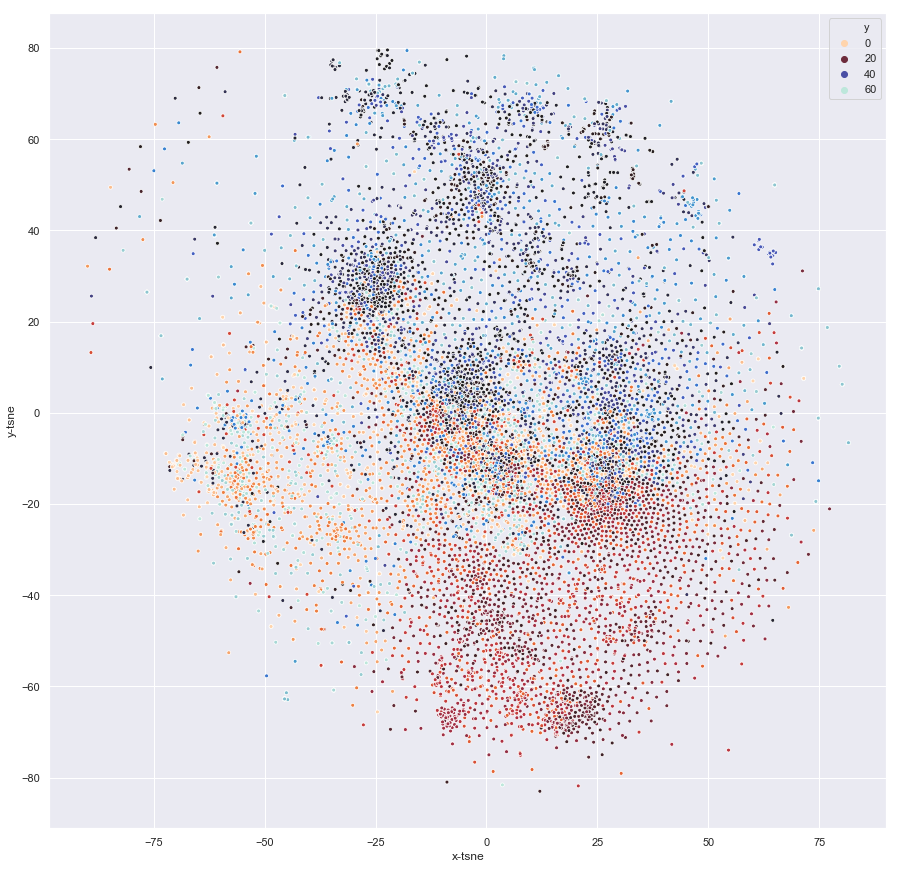

In [60]:
sns.set(rc={'figure.figsize':(15,15)})
sns.scatterplot(data=df_tsne, x='x-tsne', y='y-tsne', s=15, hue='y', palette='icefire_r')